# <span style="color:red">  **SIMULATIONS ET MÉTHODES DE MONTE CARLO**  </span>

In [11]:
import numpy as np 
from scipy.stats import multivariate_normal
import Code
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm
import time
import random

## Sommaire

- [Partie 0. Définition du cadre gaussien pour la génération des données](#partie-0-définition-du-cadre-gaussien-pour-la-génération-des-données)
  - [0.1. Génération du vrai $\theta$](#01-génération-du-vrai-theta)
  
  - [0.2. Génération de notre vecteur d'observation $\boldsymbol{x} \in \mathbb{R}^{20}$](#02-génération-de-notre-vecteur-dobservation-boldsymbolx-in-mathbbr20)

  - [0.3. Génération de la vraie log-vraisemblance et du vrai gradient associé à $\theta_{\text{true}}$ et à notre observation $\boldsymbol{x}$](#03-génération-de-la-vraie-log-vraisemblance-et-du-vrai-gradient-associé-à-thetatru-et-à-notre-observation-boldsymbolx)

  - [0.4. Génération des paramètres de l'encodeur $A \in \mathbb{R}^{20\times 20}$ et $b \in \mathbb{R}^{20}$](#04-génération-des-paramètres-de-lencodeur-a-in-mathbbr2020-et-b-in-mathbbr20)

- [Partie 1. Comparaison des estimateurs de la vraisemblance du modèle](#partie-1-comparaison-des-estimateurs-de-la-vraisemblance-du-modèle)

  - [1.1 Les estimateurs RR (Roulette Russe) et SS (Single Sample)](#11-les-estimateurs-rr-roulette-russe-et-ss-single-sample)

    - [1.1.1 Estimateur ML-SS](#111-estimateur-ml-ss)

    - [1.1.2 Estimateur ML-RR](#112-estimateur-ml-rr)
    
  - [1.2 L'estimateurs SUMO (Stochastically Unbiased Marginalization Objective (SUMO))](#12-lestimateurs-sumo-stochastically-unbiased-marginalization-objective-sumo)

  - [1.3 L'estimateurs IWAE (Autoencoder Pondéré par l'Importance)](#13-lestimateurs-iwae-autoencoder-pondéré-par-limportance)
  
  - [1.4 Comparaison entre les différents estimateurs](#14-comparaison-entre-les-différents-estimateurs)

- [Partie 2. Analyse du Biais et de la Variance des estimateurs](#partie-2-biais-variance)

- [Partie 3. Performance des estimateurs pour la SGD (descente de gradient stochastique)](#partie-3-SGD)

  - [3.1 Cadre général de la descente de gradient stochastique pour obtenir une estimation du maximum de vraisemblance](#partie-31-SGD-cadre-general)
  
  - [3.2 Calcul explicite du gradient de la log-vraisemblance](#partie-32-calcul-explicite-gradient-vraisemblance)

  - [3.3 Tirage du paramètre génératif $\theta$](#partie-33-tirage-parameter-génératif)

  - [3.4 Tirage de l'échantillon](#partie-34-tirage-echantillon)

  - [3.5 Adaptation de l'itération avec des estimation du gradient](#partie-35-adaptation-gradient)

- [Bibliographie](#bibliographie)

span style="color:blue">  **NOTATIONS**  </span> : on se donne un ensemble de données $\boldsymbol{x} = \{x^{(i)}\}_{i=1}^n$ composé de $n$ échantillons i.i.d. d'une variable continue ou discrète $x$ à valeurs dans un espace d'observations $\boldsymbol{\mathcal{X}}$ (ainsi $\boldsymbol{x} \in \boldsymbol{\mathcal{X}}$). Nous supposons que les données sont générées par un processus aléatoire impliquant une variable aléatoire continue non observée $\boldsymbol{z} = \{z^{(i)}\}_{i=1}^n$ à valeur dans un espace d'observations $\boldsymbol{\mathcal{Z}}$ (ainsi $\boldsymbol{z} \in \boldsymbol{\mathcal{Z}}$). Le processus se compose de deux étapes :


1. La valeur $z^{(i)}$ est générée à partir d'une distribution a priori $p_{\theta^*}(z)$ ;
2. Une valeur $x^{(i)}$ est générée à partir d'une distribution conditionnelle $p_{\theta^*}(x|z)$.


Nous supposons que la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ proviennent de familles paramétriques de distributions $p_{\theta}(\boldsymbol{z})$ et $p_{\theta}(\boldsymbol{x}|\boldsymbol{z})$ et on note $\Theta \subset \mathbb{R}^d$ l'espace des paramètres. On connait ainsi l'expression de ces deux distributions. En revanche une grande partie de ce processus nous est cachée : les véritables paramètres $\theta^*$ ainsi que les valeurs des $\textbf{variables latentes}$ $z^{(i)}$ nous sont inconnus. 

Connaissant l'expression de la distribution a priori $p_{\theta^*}(\boldsymbol{z})$ et la vraisemblance $p_{\theta^*}(\boldsymbol{x}|\boldsymbol{z})$ pour tout $\theta \in \Theta$, on peut définir la densité jointe $p_{\theta}(\boldsymbol{x}, \boldsymbol{z})$ sur $\boldsymbol{\mathcal{X}} \times \boldsymbol{\mathcal{Z}}$ par : 

$$
p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = p_{\theta}(\boldsymbol{x}|\boldsymbol{z}) p_{\theta}(\boldsymbol{z})
$$

<span style="color:blue">  **OBJECTIF**  </span> : on cherche à déterminer la vraie valeur du paramètre (ici $\theta^*$) ainsi que les valeurs des variables latentes. 

Une approche classique pour apprendre $\boldsymbol{\theta}$ est de choisir, si celle-ci existe, la valeur de ce paramètre qui maximise la log-vraisemblance marginale de l’ ́echantillon définie par :

$$
\ell(\boldsymbol{\theta}) = \log p_{\boldsymbol{\theta}}(\boldsymbol{x}) = \log \int_{\boldsymbol{\mathcal{Z}}} p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}) d\boldsymbol{z}
$$

<span style="color:blue">  **PROBLÈME**  </span> : l'intégrale donnée en ci-dessus est intractable (nous ne pouvons donc pas évaluer ou différencier la vraisemblance marginale).

<span style="color:blue">  **SOLUTION**  </span> : dans le but de résoudre les problèmes ci-dessus, introduisons un **modèle de reconnaissance** (paramétrique) {$ q_{\phi}(\boldsymbol{z}|\boldsymbol{x}) : \phi \in \Phi$} avec $\Phi \subset \mathbb{R}^d$. Pour tout $\phi$, $q_{\phi}(\boldsymbol{z}|\boldsymbol{x})$ est choisi comme une approximation de la véritable postérieure intractable $p_{\theta}(\boldsymbol{z}|\boldsymbol{x})$. L'idée est donc de proposer une valeur de l'a posteriori (faire une hypothèse) et d'introduire une méthode pour apprendre les paramètres du **modèle de reconnaissance** $\phi$ conjointement avec les paramètres du **modèle génératif** $\theta$.

## <span style="color:green">  **Partie 0. Définition du cadre gaussien pour la génération des données**  </span>

(Application numérique inspirée de [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf))

- Le **modèle génératif** est donné par $p_{\theta}(\boldsymbol{x}, \boldsymbol{z}) = \mathcal{N}(\boldsymbol{z}|\theta, I) \mathcal{N}(\boldsymbol{x}|\boldsymbol{z}, I)$, où $\boldsymbol{x}$ et $\boldsymbol{z} \in \mathbb{R}^{20}$, de sorte que $p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)$ et $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$. 

- La **distribution de l'encodeur** (le modèle de reconnaissance) est $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$.

- Nous considérons des perturbations aléatoires des paramètres près de la valeur optimale par une distribution gaussienne de moyenne nulle et d'écart-type $0.01$.

**Dans ce cas, on peut analytiquement calculer la vraie log-vraisemblance du modèle pour quantifier le biais et la variance de tous les estimateurs**.

Puisque $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$ est censé être une approximation de la véritable loi a posteriori donnée par $p_{\boldsymbol{\theta}}(\boldsymbol{z} | \boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$

### <span style="color:orange"> 0.1. **Génération du vrai $\theta$**  </span>

On commence par tirer le $\theta$* ($\in \mathbb{R}$) qui sera le paramètre que l'on cherchera à estimer par la suite. 

A la manière de la génération des données dans [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) : $\theta^* \sim \mathcal{N}(0, 1)$

In [2]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {int(theta_true*100)/100}")

La valeur de theta à estimer est -0.63


### <span style="color:orange"> 0.2. **Génération de notre vecteur d'observation $\boldsymbol{x} \in \mathbb{R}^{20}$**  </span>

L'idée est désormais de tirer une observation $\boldsymbol{x} \in \mathbb{R}^{20}$, chose que l'on peut faire puisque toutes les distributions nous sont données. 


In [3]:
## On se donne notre échantillon x

x, _ = Code.joint_probability(theta_true)

print(f"L'échantillon x observé est :\n \n x = {x} \n \n et on vérifique bien sa taille est celle voulue : {x.shape}")

L'échantillon x observé est :
 
 x = [ 0.25859202  0.77395797  0.82424738  1.13558739  0.1780714  -1.1688174
  0.02376592  0.2239882  -1.35704426 -2.13342591 -1.55585238 -1.66181452
  0.09740113 -4.22763984 -1.62306872 -3.84275394  0.21358162 -0.66452506
 -0.61674154  1.21699642] 
 
 et on vérifique bien sa taille est celle voulue : (20,)


### <span style="color:orange"> 0.3. **Génération de la vraie log-vraisemblance et du vrai gradient associé à $\theta_{\text{true}}$ et à notre observation $\boldsymbol{x}$**  </span>

On rappelle que l'on nous a donné que $p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta, 2I)$ pour tout $\boldsymbol{x} \in \mathbb{R}^{20}$, ainsi, on peut explicitement calculer la log-vraisemblance et du vrai gradient de $p_{\theta}$ par rapport à $\theta$. On a :

\begin{align*}
\ell (\theta) = \log p_{\theta}(\boldsymbol{x}) = \log (\mathcal{N}(\boldsymbol{x}|\theta, 2I)) &= \log \left ( \frac{1}{\sqrt{(2\pi)^{20} \det(2I)}} \exp \left\{-\frac{1}{2} (x-\theta\bm{1}_{20})^T (2I)^{-1} (x-\theta\bm{1}_{20}) \right\} \right )\\
&= \log \left ( \frac{1}{(2\pi)^{10} 2^{10}} \exp \left\{-\frac{1}{4} (x-\theta\bm{1}_{20})^T (x-\theta\bm{1}_{20}) \right\} \right )\\
&= - 10 \log (4\pi) -\frac{1}{4} (x-\theta\bm{1}_{20})^T (x-\theta\bm{1}_{20})\\
&= - 10 \log (4\pi) -\frac{1}{4} \| x - \theta \mathbf{1}_{20} \|^2\\
&= - 10 \log (4\pi) -\frac{1}{4} \sum_{i=1}^{20} (x_i - \theta)^2

\end{align*}

Et, alors 

\begin{align*}
\nabla_{\theta}\ell (\theta) = \ell '(\theta) &= \frac{1}{2} \sum_{i=1}^{20} (x_i - \theta)\\
&= \frac{1}{2} \sum_{i=1}^{20}x_i - 10 \theta \\
&= 10 \frac{1}{20} \sum_{i=1}^{20}x_i - 10 \theta \\
&= 10 (\bar{x}_{20} - \theta)
\end{align*}

In [4]:
true_likelihood = Code.true_likelihood(x, theta_true)
true_gradient = Code.true_grad(x, theta_true)

print(f"La valeur associée à la log-vraisemblance de l'échantillon x pour theta_true est : {true_likelihood} \n ")
print(f"La valeur associée au gradient de l'échantillon x pour theta_true est : \n\n {true_gradient} \n ")

La valeur associée à la log-vraisemblance de l'échantillon x pour theta_true est : -29.650894290856282 
 
La valeur associée au gradient de l'échantillon x pour theta_true est : 

 -0.6299214797410746 
 


### <span style="color:orange"> 0.4. **Génération des paramètres de l'encodeur $A \in \mathbb{R}^{20\times 20}$ et $b \in \mathbb{R}^{20}$**  </span>

Il est maintenant question de tirer notre encodeur tel que : $q_{\phi}(z|x) = \mathcal{N}\left(\boldsymbol{z}|A\boldsymbol{x} + b, \frac{2}{3}I \right)$, où $\phi = (A, b)$. **Le problème qui se pose est donc celui du choix de $A$ et de $b$**. Dans l'article [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), il nous est indiqué : 

*"Following [Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf), we consider random perturbations of the parameters near the optimal value by a zero-mean Gaussian with standard deviation 0.01"*

Ainsi, étant donné une observation $\boldsymbol{x}$,  le choix parfait pour $\phi$ serait $\phi^* = (A^*, b^*)$ où $A^* = \frac{1}{2}\boldsymbol{I}_{20} \in \mathbb{R}^{20 \times 20}$ et $b^* = [\frac{\theta^*}{2}, ..., \frac{\theta^*}{2}]^T \in \mathbb{R}^{20} $. Suivant l'indication dans l'article, nous nous plaçons dans un cas où on aurait réussi à inférer de manière convenable la loi $p_{\theta}(\boldsymbol{z}|\boldsymbol{x}) = \mathcal{N}\left( \frac{\theta + x}{2}, \frac{1}{2}I \right)$, mais pas parfaitement. Ainsi,  on introduit de la même façon que dans l'article [[Rainforth et al. (2018)](https://arxiv.org/pdf/1802.04537.pdf) une perturbation autour de la valeur optimale du paramètre $\phi$. Cette perturbation se caractérise par le fait chaque dimension de chaque paramètre a été décalée de manière aléatoire par rapport à sa valeur optimale en utilisant une gaussienne centrée en zéro avec un écart-type de 0,01.


In [5]:
dim = 20 

## On calcule les valeurs optimales de A et de b
A = 0.5 * np.eye(dim)
b = 0.5 * theta_true * np.ones(dim)

## On calcule les valeurs perturbées de A et de b, qui sont FIXÉES dans la suite
noised_A, noised_b = Code.noised_params(A, b)

print(f"On vérifie que les tailles de A, b et x coincident :\n \n taille A : {A.shape} \n taille b : {b.shape} \n taille x : {x.shape}")

On vérifie que les tailles de A, b et x coincident :
 
 taille A : (20, 20) 
 taille b : (20,) 
 taille x : (20,)


## <span style="color:green">  **Partie 1. Comparaison des estimateurs de la vraisemblance du modèle**  </span>

### <span style="color:orange">  **1.1 Les estimateurs RR (Roulette Russe) et SS (Single Sample)**  </span>

On rappelle rapidement la manière dont sont définis les estimateurs RR et SS, utilisés plus tard pour construire SUMO, ML-SS et ML-RR.  
Désignons une quantité d'intérêt par $I_\infty = \log p_\theta(\boldsymbol{x})$. Supposons que $I_\infty$ puisse être écrite comme

$$
I_\infty = \mathbb{E}[I_0] + \sum_{k=0}^\infty \mathbb{E}[\Delta_k] 
$$

pour les variables aléatoires $I_0$ et $(\Delta_k)_{k\geq0}$. Nous pouvons estimer $I_\infty$ de manière non biaisée via les estimateurs suivants ss ou rr :

$$
ss = I_0 + \frac{\Delta_K}{p(K)}, \quad rr = I_0 + \sum_{k=0}^K \frac{\Delta_k}{\mathbb{P}(K \geq k)}
$$

où $K \sim Geom(r)$.

Pour chacun de ces estimateurs, nous allons suivre la méthodologie du Monte Carlo multiniveau (voir cet [article](https://web.stanford.edu/~glynn/papers/2015/BlanchetG15.html)) qui repose sur un schéma alternatif astucieux pour construire $\Delta_k$, qui peut garantir la construction d'estimateurs non biaisés de $\ell(\boldsymbol{\theta})$ qui admettent une variance finie et peuvent être calculés en un temps attendu fini.

Nous désignons par $\boldsymbol{z}^O_i$, $\boldsymbol{z}^E_i$ deux séquences indépendantes d'échantillons i.i.d. de $q_\phi$, où $O$, $E$ désignent respectivement impair (odd), pair (even), et $w^O_i$, $w^E_i$ les poids d'importance correspondants. Ensuite, nous définissons $I_0 = \hat{\ell}^{(1)}(\boldsymbol{\theta})$ et

\begin{align*}
\Delta^\text{ML}_k = \hat{\ell}^{(2^{k+1})}_{O\cup E}(\boldsymbol{\theta}) - \frac{1}{2} \left( \hat{\ell}^{(2^k)}_O (\boldsymbol{\theta}) + \hat{\ell}^{(2^k)}_E (\boldsymbol{\theta}) \right),
\end{align*}

où $\hat{\ell}^{(2^k)}_O (\boldsymbol{\theta}) = \log \left(\frac{1}{2^k} \sum_{i=1}^{2^k} w(z^{O}_i) \right)$ est calculé en utilisant les échantillons impairs $\{z^O_i\}_{i=1}^{2^k}$, $\hat{\ell}^{(2^k)}_E (\boldsymbol{\theta}) = \log \left(\frac{1}{2^k} \sum_{i=1}^{2^k} w(z^{E}_i) \right)$ en utilisant les échantillons pairs $\{z^E_i\}_{i=1}^{2^k}$, et $\hat{\ell}^{(2^{k+1})}_{O\cup E} (\boldsymbol{\theta})$ en utilisant $\{z^O_i\}_{i=1}^{2^k} \cup \{z^E_i\}_{i=1}^{2^k}$. Nous désignons les estimateurs SS/RR multiniveaux correspondants de $\hat{\ell}(\boldsymbol{\theta})$ comme $\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta})$ et $\hat{\ell}^\text{ML-RR}(\boldsymbol{\theta})$, et collectivement comme $\hat{\ell}^\text{ML}(\boldsymbol{\theta})$.

Ainsi, 

$$
\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta}) = I_0 + \frac{\Delta^{\text{ML}}_\mathcal{K}}{p(\mathcal{K})}, \quad \hat{\ell}^\text{ML-RR}(\boldsymbol{\theta}) = I_0 + \sum_{k=0}^{K} \frac{\Delta^{\text{ML}}_k}{\mathbb{P}(\mathcal{K} \geq k)},
$$

En abscisse, on considère un segment centré autour de $\theta^*$, la vraie valeur du paramètre. Pour chaque point de ce segment, on calcule l'estimation réalisée par $\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta})$ ou $\hat{\ell}^\text{ML-RR}(\boldsymbol{\theta})$ et on la trace sur les graphiques suivant. Le courbe en rouge représente la vraie fonction de vraisemblance, calculée analytiquement. 

#### <span style="color:red">  **1.1.1 Estimateur ML-SS**  </span>

On choisit arbitrairement un nombre de 15 simulations et de 60 points pour des questions de vitesse de calcul. 

In [6]:
n_simulations = 15 
num_runs = 10
r = 0.6
#k_IWAE = 5 

Progression:   0%|          | 0/30 [00:00<?, ?it/s]

Progression: 100%|██████████| 30/30 [00:37<00:00,  1.26s/it]


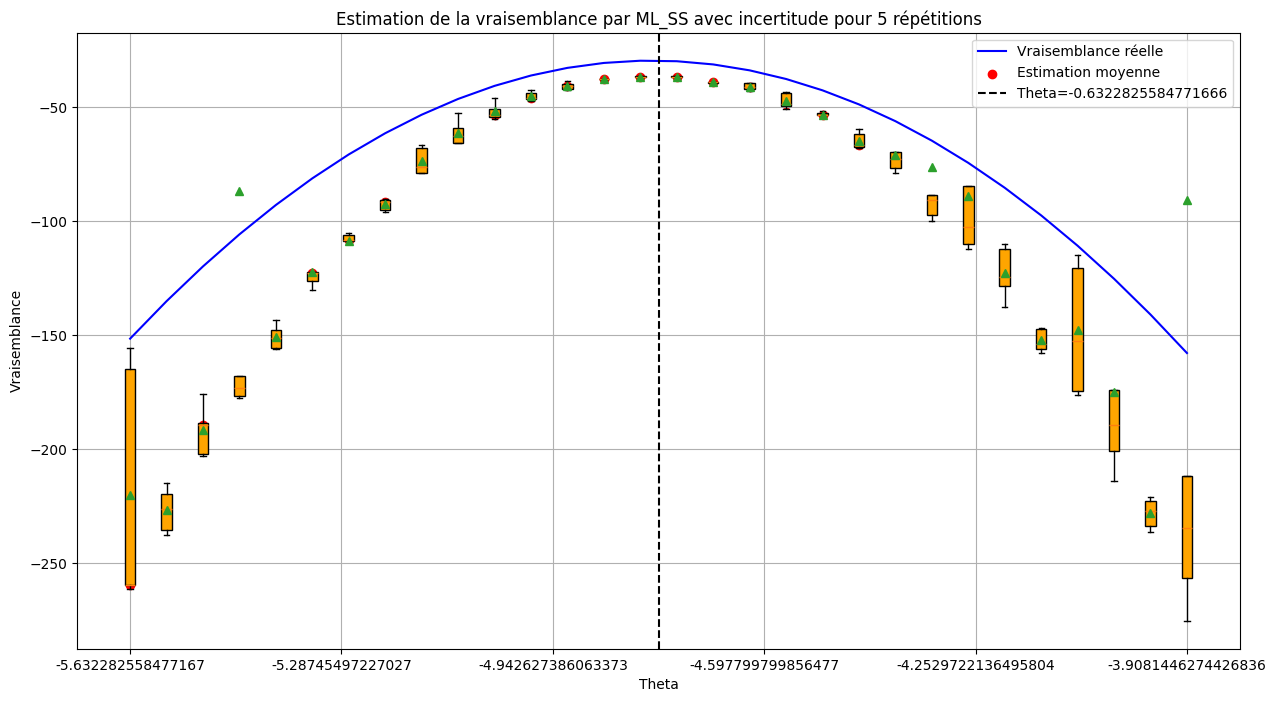

In [8]:
Code.plot_errors_likelihood(r, theta_true, x, noised_A, noised_b, n_simulations, num_runs, 'ML_SS')

In [9]:
theta_min = theta_true - 5
theta_max = theta_true + 5
num_points = 30
theta_values = np.linspace(theta_min, theta_max, num_points)
theta_values

array([-5.63228256, -5.28745497, -4.94262739, -4.5977998 , -4.25297221,
       -3.90814463, -3.56331704, -3.21848946, -2.87366187, -2.52883428,
       -2.1840067 , -1.83917911, -1.49435152, -1.14952394, -0.80469635,
       -0.45986877, -0.11504118,  0.22978641,  0.57461399,  0.91944158,
        1.26426917,  1.60909675,  1.95392434,  2.29875192,  2.64357951,
        2.9884071 ,  3.33323468,  3.67806227,  4.02288986,  4.36771744])

Nous pouvons observer sur ce graphique que l'estimateur $\hat{\ell}^\text{ML-SS}(\boldsymbol{\theta})$ sous-estime faiblement la valeur de la log-vraisemblance. Néanmoins, ce biais est faible et diminue à mesure que l'on se rapproche de la valeur du "vrai" paramètre $\theta$ qui caractérise la loi de nos observations. Ainsi, nous pouvons raisonnablement penser que la précision de notre estimateur augmente rapidement avec le nombre d'observations. 

De plus, nous supposons que la descente de gradient opérée avec cet estimateur convergera vers une valeur proche du maximum de vraisemblance du modèle puisque l'on voit que les maximums des deux courbes coïncident assez précisement avec la "vraie" valeur du paramètre $\theta$. 

On va désormais s'intéresser à l'estimation de $\nabla_{\theta} l(\theta)$ par notre estimateur ML-SS. L'objectif étant de voir à quel point cet estimateur nous permettra, par la suite, d'approximer $\theta^*$ à l'aide d'une descente de gradient. 

De la même façon, 

In [10]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, n_simulations,'ML_SS')

De la même façon, on voit ici qu'à mesure que l'on se rapproche du "vrai" paramètre $\theta$ du modèle, l'estimateur du gradient de la log-vraisemblance du modèle par l'approche ML SS coïncide assez précisement avec la valeur du gradient que l'on a pu calculer analytiquement. 

#### <span style="color:red">  **1.1.2 Estimateur ML-RR**  </span>

Pour créer un estimateur non biaisé de la fonction de $\log p_{\boldsymbol{\theta}}(\boldsymbol{x})$, nous utilisons l'estimateur de la roulette russe (voir [Kahn, 1955](https://www.rand.org/content/dam/rand/pubs/papers/2008/P766.pdf)). Cet estimateur est utilisé pour estimer la somme de séries infinies, où l'évaluation de chaque terme de la série nécessite presque sûrement seulement une quantité finie de calcul. Intuitivement, l'estimateur de la roulette russe repose sur une troncature aléatoire et une pondération de chaque terme pour tenir compte de la possibilité de ne pas calculer ces termes.

Pour illustrer l'idée, soit $\tilde{\Delta}_k$ $k$-ième terme d'une série infinie. Supposons que la somme partielle de la série $\sum_{k=1}^{+\infty}\tilde{\Delta}_k$ converge vers une quantité que nous souhaitons obtenir. Nous pouvons construire un estimateur simple en calculant toujours le premier terme puis en lançant une pièce $b \sim$ Bernoulli($q$) pour déterminer si nous arrêtons ou continuons à évaluer les termes restants. Avec une probabilité de $1 − q$, nous calculons le reste de la série. En pondérant à nouveau les termes futurs restants par $\frac{1}{1-q}$, nous obtenons un estimateur non biaisé :

$$
\tilde{Y} = \tilde{\Delta}_0 + \left(\frac{\sum_{k=1}^{+\infty}\tilde{\Delta}_k}{1-q}\right)\mathbb{1}_{b=0} + (0)\mathbb{1}_{b=1}
$$

$$
\mathbb{E}[\tilde{Y}] = \tilde{\Delta}_0 + \frac{\sum_{k=1}^{+\infty}\tilde{\Delta}_k}{1-q}(1-q) = \sum_{k=0}^{+\infty}\tilde{\Delta}_k
$$
Pour obtenir l'estimateur de la "roulette russe" (rr) (Forsythe & Leibler, 1950), nous appliquons cette astuce de manière répétée aux termes restants. En effet, en voyant le nombre de termes comme une variable aléatoire $\mathcal{K}$ à valeurs dans $1, 2, ...$ à utiliser dans la sommation (c'est-à-dire, le nombre de lancers de pièce réussis) dont la distribution a pour fonction de masse de probabilité $p(\mathcal{K}) = P(\mathcal{K} = k)$ de support les entiers positifs. Avec $\mathcal{K}$ tiré de $p(\cdot)$, l'estimateur prend la forme :

$$
\hat{Y}(\mathcal{K}) = \sum_{k=0}^K \frac{\tilde{\Delta}_k}{\mathbb{P}(\mathcal{K} \geq k)}
$$

$$
\mathbb{E}_{\mathcal{K} \sim p(\cdot)}[\hat{Y}(\mathcal{K})] = \sum_{k=0}^{+\infty}\tilde{\Delta}_k
\tag{*}
$$

**Cependant, la variance de cet estimateur dépend du choix de p(K) et peut potentiellement être très grande voire infinie.**

EST CE QUON LAISSE Ça

Progression:   0%|          | 0/30 [00:00<?, ?it/s]

Progression: 100%|██████████| 30/30 [00:23<00:00,  1.26it/s]


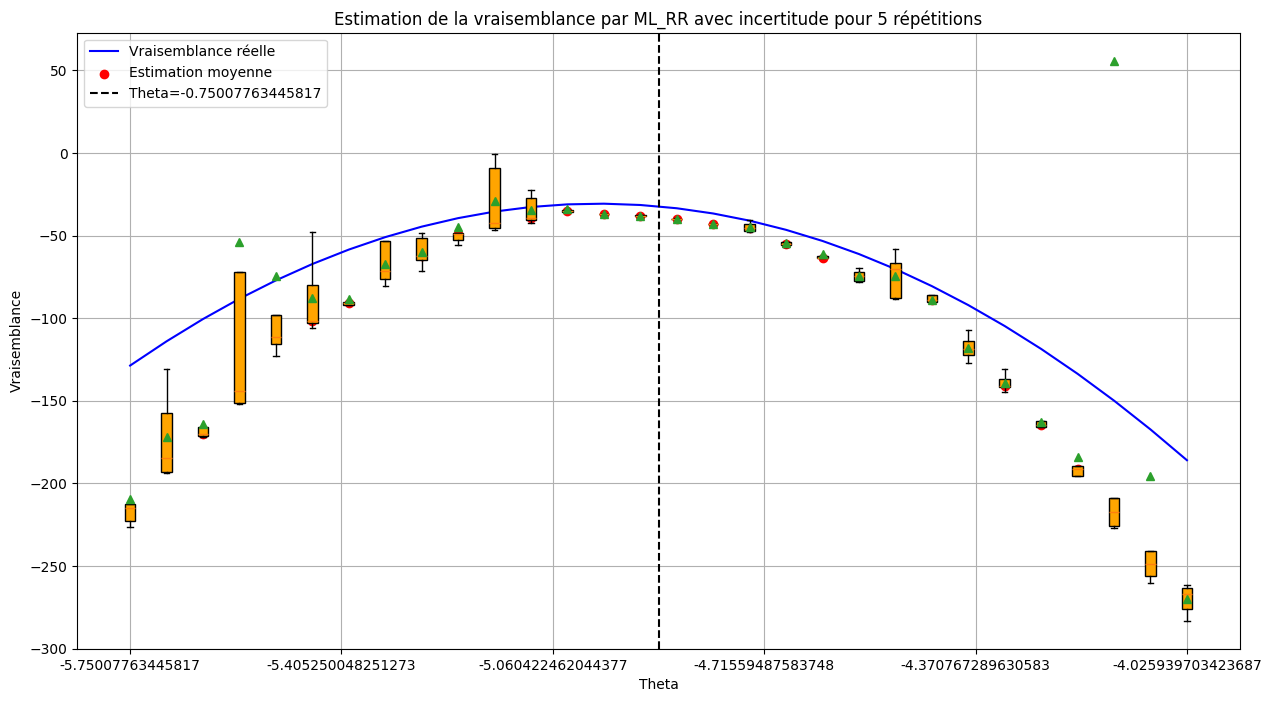

In [10]:
n_simulations = 15
r = 0.6

Code.plot_errors_likelihood(r, theta_true, x, noised_A, noised_b, n_simulations, 5, 'ML_RR')

De la même façon, on voit que l'estimateur est faiblement biaisé et dont le maximum coïncide précisément avec le "vrai" paramètre $\theta$ du modèle. 

In [9]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, 15, "ML_RR")

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:254: RuntimeWarning:

divide by zero encountered in log

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:258: RuntimeWarning:

divide by zero encountered in log

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:256: RuntimeWarning:

divide by zero encountered in log

/Users/tomrossa/Documents/ENSAE/Monte Carlo Method/Project/MLMC_Unibaised_Gradient_Estimation_for_Deep_LVM/Code.py:257: RuntimeWarning:

divide by zero encountered in log



De même pour l'estimation du gradient de la log-vraisemblance, la précision de l'estimation est grande au voisinnage du "vrai" $\theta$. Le biais augmente à mesure que l'on s'en éloigne. 

### <span style="color:orange">  **1.2 L'estimateurs SUMO (Stochastically Unbiased Marginalization Objective (SUMO))**  </span>

On pose 
\begin{align*}
\Delta^{\text{SUMO}}_k &:= \hat{\ell}^{(k+2)}(\boldsymbol{\theta}) - \hat{\ell}^{(k+1)}(\boldsymbol{\theta})\\
&:= \log \left( \frac{1}{k+2} \sum_{i=1}^{k+2} w(\boldsymbol{z}_i) \right) - \log \left( \frac{1}{k+1} \sum_{i=1}^{k+1} w(\boldsymbol{z}_i) \right),
\end{align*}

où on rappelle que $w(\boldsymbol{z}) := \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}$.

On applique l'estimateur $RR$ pour construire notre estimateur, que nous appelons $\textbf{SUMO}$ (Stochastically Unbiased Marginalization Objective) qui correspond précisément à l'estimateur de la roulette russe pour $\Delta^{\text{SUMO}}_k$. Ainsi, 
$$
\hat{\ell}^{\text{SUMO}}(\boldsymbol{\theta}) := I_0 + \sum^K_{k=0} \frac{\Delta^{\text{SUMO}}_k}{P(\mathcal{K} \geq k)}
$$
    
où $\mathcal{K} \sim p(\cdot)$ une distrubtion de support dans $\mathbb{N}$

Progression:   0%|          | 0/30 [00:00<?, ?it/s]

Progression: 100%|██████████| 30/30 [00:10<00:00,  2.87it/s]


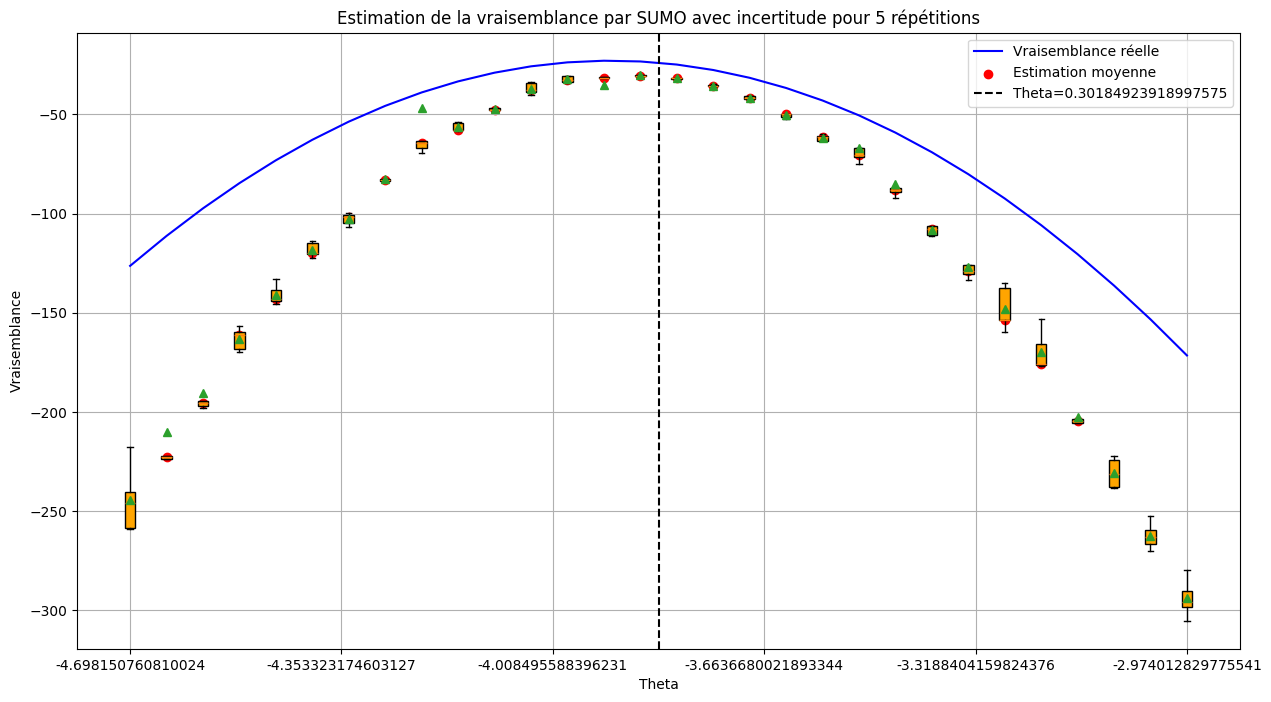

In [18]:
n_simulations = 15 
r = 0.6
n_runs = 15

Code.plot_errors_likelihood(r=r, theta_true=theta_true, x=x, noised_A=noised_A, noised_b=noised_b, n_simulations=n_simulations, n_runs=n_runs, methode='SUMO')

In [20]:
Code.plot_gradient(0.6, x, noised_A, noised_b, theta_true, 20, 'SUMO')

### <span style="color:orange">  **1.3 L'estimateurs IWAE (Autoencoder Pondéré par l'Importance)**  </span>

Voir l'article séminal sur l'IWAE [ici](https://arxiv.org/pdf/1509.00519.pdf).

L'IWAE utilise cette architecture avec à la fois un **réseau génératif** (paramètre $\boldsymbol{\theta}$) et un **réseau de reconnaissance** (paramètre $\phi$). **La différence est qu'il est entraîné à maximiser une autre borne inférieure** sur $\log p_{\boldsymbol{\theta}}(\boldsymbol{x})$. En particulier, nous utilisons la borne inférieure suivante, correspondant à l'estimation de pondération d'importance à $k$ échantillons de la log-vraisemblance :

\begin{align*}
\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi) &= \mathbb{E}_{\boldsymbol{z}_1,\dots,\boldsymbol{z}_k \underset{i.i.d}{\sim} q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}\left[\log \frac{1}{k} \sum_{i=1}^{k} \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}_i)}{q_{\phi}(\boldsymbol{z}_i | \boldsymbol{x})}\right ]
\end{align*}

Ici, $\boldsymbol{z}_1, \dots, \boldsymbol{z}_k$ sont échantillonnés indépendamment du modèle de reconnaissance. Le terme à l'intérieur de la somme correspond aux poids d'importance non normalisés pour la distribution conjointe, que nous noterons $w_i = \frac{p(\boldsymbol{x}, \boldsymbol{z}_i)}{q_{\phi}(\boldsymbol{z}_i | \boldsymbol{x})}$. 

L'optimisation de $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ est effectuée conjointement en $\boldsymbol{\theta}$ et $\phi$. 

Il existe deux propriétés de l'IWAE qui nous permettront de le modifier pour produire un estimateur non biaisé :
1. Il est consistant, i.e. lorsque le nombre d'échantillons $k$ augmente, l'espérance de $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ converge vers $\log p_{\boldsymbol{\theta}}(\boldsymbol{x})$ : 
$$
\log p_{\boldsymbol{\theta}}(\boldsymbol{x}) = \lim_{k \rightarrow +\infty} \mathbb{E}[\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)]
$$

2. Il est également croissant en espérance : 
$$
\mathbb{E}[\ell_{\text{IWAE}}^{(k+1)}(\boldsymbol{\theta}, \phi)] \geq \mathbb{E}[\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)]
$$ 

De la même façon que pour les estimateurs précédents, on trace les estimations de l'IWAE sur une plage autour de $\theta^*$

Progression:   0%|          | 0/30 [00:00<?, ?it/s]

Progression: 100%|██████████| 30/30 [00:07<00:00,  4.00it/s]


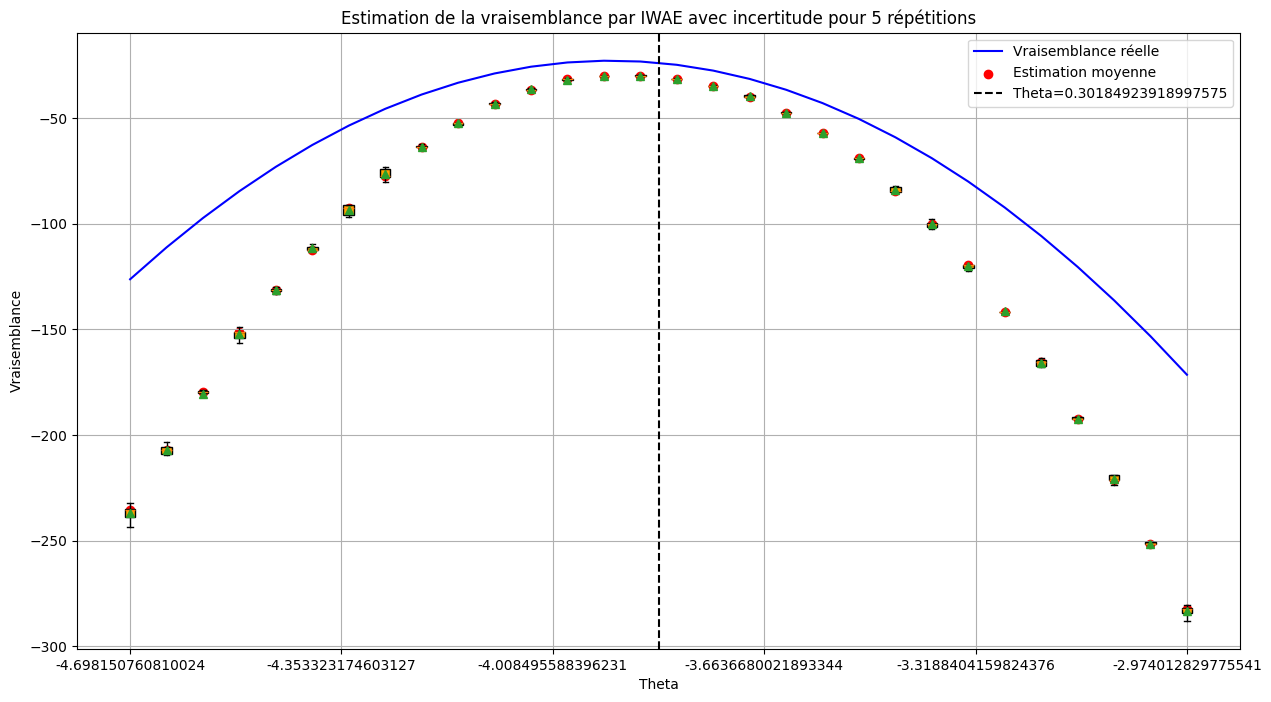

In [14]:
n_simulations = 15 
k_IWAE = 20
r = 0.6
n_runs = 10

Code.plot_errors_likelihood(r, theta_true, x, noised_A, noised_b, n_simulations, n_runs, 'IWAE')

On remarque que l'estimateur de $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ que l'on a construit possède un biais plus important que les précédents. On observe de même un léger décalage du maximum de la courbe obtenue via cet estimateur et la courbe de la vraie log-vraisemblance que nous avons calculé analytiquement. Cela s'explique par le fait qu'à distance finie, $\ell_{\text{IWAE}}^{(k)}(\boldsymbol{\theta}, \phi)$ correspond à la maximisation d'une borne inférieur de la log-vraisemblance puisque l'on peut faire la réécriture suivante de $\ell (\boldsymbol{\theta})$ : 

\begin{align*}
\ell (\boldsymbol{\theta}) &= \log p_{\boldsymbol{\theta}}(\boldsymbol{x})\\
&= \log \int_{\boldsymbol{\mathcal{Z}}} p_{\boldsymbol{\theta}}(\boldsymbol{x}, \boldsymbol{z}) d\boldsymbol{z}\\
&= \log \int_{\boldsymbol{\mathcal{Z}}} \frac{p_{\theta}(\boldsymbol{x}, \boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}q_{\phi}(\boldsymbol{z}|\boldsymbol{x})d\boldsymbol{z}\\
&= \log \mathbb{E}[\frac{p_{\theta}(\boldsymbol{x}, \boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}]\\
&\geq \mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log \frac{p_{\theta}(\boldsymbol{x}, \boldsymbol{z})}{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}] \quad \text{Inégalité de Jensen}\\
&= \mathbb{E}_{q_{\phi}(\boldsymbol{z}|\boldsymbol{x})}[\log \boldsymbol{w}(\boldsymbol{x})]\\
&= \mathcal{L}(\boldsymbol{\theta}, \phi; \boldsymbol{x})
\end{align*}

Ce dernier terme $\mathcal{L}(\boldsymbol{\theta}, \phi; \boldsymbol{x})$ est appelé la <span style="color:blue"> borne inférieure variationnelle de l'évidence (ELBO dans l'article) </span>  du point de données $\boldsymbol{x} \in \boldsymbol{\mathcal{X}}$.


Fixons k_IWAE = 5 et comparons les résultats : 

In [ ]:
k_IWAE = 5

Code.plot_likelihood(r, x, noised_A, noised_b, theta_true,  n_simulations, k_IWAE, "IWAE")

Progression:   0%|          | 0/60 [00:00<?, ?it/s]

Progression: 100%|██████████| 60/60 [00:05<00:00, 11.55it/s]


In [7]:
Code.plot_gradient(r, x, noised_A, noised_b, theta_true, n_simulations, 'IWAE')

Comme vu précédent, à moins que $q_{\phi}(\boldsymbol{z}|\boldsymbol{x})$ corresponde exactement à $p_{\boldsymbol{\theta}}(\boldsymbol{z}|\boldsymbol{x})$, alors en général $\nabla_{\boldsymbol{\theta}}\ell_{\text{IAWE}}^{(k)}(\boldsymbol{\theta}, \phi) \neq \nabla_{\boldsymbol{\theta}}\ell(\boldsymbol{\theta})$. Ainsi, la descente de gradient stochastique opérée avec cet estimateur peut optimiser $\boldsymbol{\theta}$ loin du vrai maximiseur de $\mathcal{L}(\boldsymbol{\theta})$ à moins que $k$ soit grand.

### <span style="color:orange">  **1.4 Comparaison entre les différents estimateurs**  </span>

Dans cette partie, nous allons comparer les estimateurs sur un même graphique. 

In [ ]:
Code.plot_likelihood(r, x, noised_A, noised_b, theta_true, n_simulations, "all")

Progression: 100%|██████████| 60/60 [02:06<00:00,  2.11s/it]


On fait de même pour le gradient : 

In [7]:
Code.plot_gradient(r, x, noised_A, noised_b, theta_true, n_simulations, 'all')

Progression IWAE (5 échantillons):   0%|          | 0/15 [00:00<?, ?it/s]

Progression IWAE (5 échantillons): 100%|██████████| 15/15 [00:00<00:00, 52.96it/s]


## <span style="color:green">  **Partie 2. Analyse du Biais et de la Variance des estimateurs**  </span>

Dans cette partie, nous allons comparer les différents estimateurs de la vraisemblance et du gradient en termes de Biais et de Variance (Figure 2 dans la Section de 9 de [l'article](https://proceedings.mlr.press/v130/shi21d.html)).

Le biais d'un estimateur de la vraisemblance $ \ell({\theta})$ est donné par : ${\displaystyle {\text{Biais}}({\hat \ell({\theta })})\equiv \mathbb {E} [{\hat \ell ({\theta }})]-\ell(\theta) }$.

La variance d'un estimateur de la vraisemblance $ \ell({\theta})$ est donné par : $ \text{Var}(\hat\ell({\theta})) = \mathbb{E}\left[(\hat\ell({\theta}) - \mathbb{E}[\hat\ell({\theta})])^2 \right]$

A partir de ces formules, nous allons tracer le biais au carré de l'estimation de la log-vraisemblance pour chacune des méthodes. En abscisse, nous opérerons comme dans l'article et nous ferons varier le coût computationnel espéré. C'est-à-dire que nous ferons varier la taille de l'échantillon $z_i \underset{i.i.d}{\sim} q_{\phi}(\cdot|x)$ pour $i = 1, ..., k$. 

On rappelle que, pour les estimateurs SUMO, ML_SS et ML_RR, la taille de cet échantillon est tirée aléatoirement et dépend de : $\mathcal{K} \sim p(\cdot)$ une distrubtion de support dans $\mathbb{N}$. Pour des raisons de clarté et de vitesse de calcul, nous calculerons successivement le biais au carré des estimateurs pour des échantillons de taille $i = 1, ..., k$. 

Dans notre cas, $K \sim \text{Geom}(r)$ et donc opérer de cette manière est équivalent à ce qui est réalisé dans l'article où les auteurs font varier l'"expected computational cost". Cette unité est en fait l'ordre de grandeur du nombre d'opérations pour calcul de l'estimateur selon la taille de l'échantillon, soit $O(2^{k+1})$. Ainsi, faire varier cette unité entre 4 et 256 revient à faire varier $k$ de 1 à 7, ce que nous allons faire : 

In [7]:
Code.plot_bias_likelihood(x, theta_true, noised_A, noised_b, 7, 100)

Progression:   0%|          | 0/28 [00:00<?, ?it/s]

 
 Étape : 1 / 7 



Progression SUMO (3 échantillons):   0%|          | 0/100 [00:00<?, ?it/s]

Progression:  14%|█▍        | 4/28 [00:07<00:41,  1.73s/it]

 
 Étape : 2 / 7 



Progression:  29%|██▊       | 8/28 [00:16<00:41,  2.06s/it]

 
 Étape : 3 / 7 



Progression:  43%|████▎     | 12/28 [00:26<00:39,  2.48s/it]

 
 Étape : 4 / 7 



Progression:  57%|█████▋    | 16/28 [00:41<00:37,  3.16s/it]

 
 Étape : 5 / 7 



Progression:  71%|███████▏  | 20/28 [01:00<00:34,  4.35s/it]

 
 Étape : 6 / 7 



Progression:  86%|████████▌ | 24/28 [01:32<00:26,  6.62s/it]

 
 Étape : 7 / 7 



Progression: 100%|██████████| 28/28 [02:24<00:00,  5.17s/it]


Variance de la log-vraisemblance : 

In [7]:
Code.plot_variance_likelihood(x, theta_true, noised_A, noised_b, 9, 100, 10)

Progression:   0%|          | 0/36 [00:00<?, ?it/s]

 
 Étape : 1 / 9 



Progression:   3%|▎         | 1/36 [01:14<43:25, 74.44s/it]

 
 Étape : 2 / 9 



Progression:  14%|█▍        | 5/36 [02:43<15:28, 29.94s/it]

 
 Étape : 3 / 9 



Progression:  25%|██▌       | 9/36 [04:39<13:15, 29.45s/it]

 
 Étape : 4 / 9 



Progression:  36%|███▌      | 13/36 [07:29<13:29, 35.20s/it]

 
 Étape : 5 / 9 



Progression:  47%|████▋     | 17/36 [11:03<13:23, 42.29s/it]

 
 Étape : 6 / 9 



Progression:  58%|█████▊    | 21/36 [16:52<14:33, 58.22s/it]

 
 Étape : 7 / 9 



Progression:  69%|██████▉   | 25/36 [25:54<15:26, 84.24s/it]

 
 Étape : 8 / 9 



Progression:  81%|████████  | 29/36 [42:03<15:49, 135.57s/it]

 
 Étape : 9 / 9 



Progression: 100%|██████████| 36/36 [1:18:52<00:00, 131.46s/it]


Biais au carré de l'estimateur du gradient (on remarque que l'on a des résultats robustes pour n = 50)

In [8]:
Code.plot_bias_gradient(x, theta_true, noised_A, noised_b, 6, 50)

Progression:   0%|          | 0/24 [00:00<?, ?it/s]

 
 Étape : 1 / 6 



Progression:  17%|█▋        | 4/24 [02:49<13:28, 40.42s/it]

 
 Étape : 2 / 6 



Progression:  33%|███▎      | 8/24 [06:28<13:08, 49.31s/it]

 
 Étape : 3 / 6 



Progression:  50%|█████     | 12/24 [10:44<11:45, 58.79s/it]

 
 Étape : 4 / 6 



Progression:  67%|██████▋   | 16/24 [17:08<11:18, 84.75s/it] 

 
 Étape : 5 / 6 



Progression:  83%|████████▎ | 20/24 [27:19<08:34, 128.52s/it]

 
 Étape : 6 / 6 



Progression: 100%|██████████| 24/24 [45:30<00:00, 113.76s/it]


Variance de l'estimateur du gradient (on met 20 simus parce que plus c'est infaisable) : 

In [9]:
Code.plot_variance_gradient(x, theta_true, noised_A, noised_b, 6, 15, 10)

Progression:   0%|          | 0/24 [00:00<?, ?it/s]

 
 Étape : 1 / 6 



Progression:   4%|▍         | 1/24 [09:10<3:30:52, 550.12s/it]

 
 Étape : 2 / 6 



Progression:  21%|██        | 5/24 [20:24<1:11:21, 225.34s/it]

 
 Étape : 3 / 6 



Progression:  38%|███▊      | 9/24 [39:40<1:05:04, 260.32s/it]

 
 Étape : 4 / 6 



Progression:  54%|█████▍    | 13/24 [1:45:28<1:46:16, 579.67s/it]

 
 Étape : 5 / 6 



Progression:  71%|███████   | 17/24 [10:01:56<6:16:35, 3227.98s/it]

 
 Étape : 6 / 6 



Progression: 100%|██████████| 24/24 [11:26:03<00:00, 1715.13s/it]  


## <span style="color:green">  **Partie 3. Performance des estimateurs pour la SGD (descente de gradient stochastique)**  </span>


Dans cette partie, nous évoluons la performance de l'algorithme de descentes de gradient stochastique lorsque l'on remplace la valeur du vrai gradient par les valeurs des estimateur de celui-ci, que nous avons étudié précédemment. Dans le cadre de cette partie, nous tirons un nouveau paramètre $\theta$ ainsi qu'un nouvel échantillon d'observation qui seront fixés dans cette partie.

### <span style="color:orange">  **3.1. Cadre général de la descente de gradient stochastique pour obtenir une estimation du maximum de vraisemblance**  </span>

On se donne un échantillon d'observations $\boldsymbol{x} \in \mathbb{R}^{20} = [x^{(1)}, ..., x^{(20)}]^T$ tiré selon une loi paramétrée par $\theta$, qui est donc le paramètre du modèle probabiliste que nous souhaitons estimer. La log-vraisemblance des données observées $\ell (\theta) = \log p_{\theta}(\boldsymbol{x}) = \sum_{i=1}^{20} \log p_{\theta}(x^{(i)})$ est maximisée pour obtenir une estimation de maximum de vraisemblance (EMV) du paramètre $\theta$. 

En utilisant la **descente de gradient stochastique (SGD)**, l'algorithme pour estimer les paramètres peut être formulé comme suit :


1. **Initialisation** : On choisit un $\theta^{(0)}$ De manière aléatoire ou déterministe. On peut par exemple choisir une telle valeur à partir d'une première approximation.

2. **Itération** : À chaque itération $t$, les paramètres $\theta$ sont mis à jour en utilisant un échantillon aléatoire de données $x^{(i)}$ (donc pour $i \in \{1, ..., 20\}$) tiré de l'ensemble de données et on a alors : 
\begin{equation}
\theta^{(t+1)} = \theta^{(t)} + \eta \nabla_{\theta} \log p_{\theta^{(t)}}(x^{(i)}),
\end{equation}

    où $\eta$ est le **taux d'apprentissage** (également appelé pas d'apprentissage) et $\nabla_{\theta} \log p_{\theta^{(t)}}(\boldsymbol{x}^{(i)})$ est le gradient du logarithme de la vraisemblance conditionnelle évalué pour l'échantillon $\boldsymbol{x}^{(i)}$ à l'itération $t$. 

3. **Convergence** : On répète $(1)$ jusqu'à ce qu'un critère d'arrêt prédéfini soit satisfait. Par exemple, on peut fixer pour un $\epsilon$ donné le critère d'arrêt suivant :  
$$ 
\| \theta^{(t+1)} - \theta^{(t)} \| < \epsilon
$$


### <span style="color:orange">  **3.2. Calcul explicite du gradient de la log-vraisemblance**  </span>

Dans l'article, pour effectuer l'expérience empirique, on nous donne la valeur explicite de la densité avec laquelle on tire les observations $\boldsymbol{x}$. On nous donne : 

$$
p_{\theta}(\boldsymbol{x}) = \mathcal{N}(\boldsymbol{x}|\theta \mathbf{1}_{20}, 2\mathbf{I}_{20}) = \frac{1}{(4\pi)^{10}} \exp \left\{ -\frac{1}{4} (\boldsymbol{x} - \theta \mathbf{1}_{20})^T  (\boldsymbol{x} - \theta \mathbf{1}_{20}) \right\}
$$

Ainsi, on a : 

$$
\log p_{\theta}(\boldsymbol{x}) = \sum_{i=1}^{20}  \log p_{\theta}(x^{(i)}) = \sum_{i=1}^{20} \log \left( \frac{1}{2\sqrt{\pi}} \exp\left(-\frac{(x - \theta)^2}{4}\right) \right)
$$

Une fois cette expression explicite de la log-vraisemblance obtenue, on peut calculer explicitement le gradient de celle-ci **par rapport au paramètre  $\theta$**. On a : 

$$
\nabla_{\theta} \log p_{\theta} (\boldsymbol{x}) = \sum_{i=1}^{20}  \log \nabla_{\theta} p_{\theta}(x^{(i)}) = \frac{1}{2} \sum_{i=1}^{20} (x^{(i)} - \theta)
$$

Si bien que l'on retrouve la version du gradient **en un point** de l'échantillon $\boldsymbol{x}$ que l'on utilise dans l'étape itérative : 

$$
\nabla_{\theta} \log p_{\theta}(x^{(i)}) = \frac{1}{2} (x^{(i)} - \theta)
$$

A MODIFIER + ERREUR D

### <span style="color:orange">  **3.3. Tirage du paramètre génératif $\theta$**  </span>

Avant toute chose, on tire une valeur du paramètre $\theta$ que l'on considère comme étant la quantité que l'on souhaite approximer dans la suite de cette partie. On sait d'après le cadre de l'application numérique de l'article que $\theta \sim \mathcal{N}(1, 0)$. **On a tiré la valeur de référence au début de ce notebook**.

In [2]:
#theta_true = np.random.multivariate_normal(np.zeros(20), np.identity(20))
theta_true = np.random.normal(0, 1)
print(f"La valeur de theta à estimer est {theta_true}")

La valeur de theta à estimer est 0.03463179933899703


### <span style="color:orange"> **3.4. Tirage de l'échantillon**  </span>

On a tiré au début de ce notebook, la valeur de $\boldsymbol{x} \in \mathbb{R}^{20 \times 20}$ que l'on a observé. 

In [3]:
def p_theta_x(theta_val):
    
    x = []

    for _ in range(20):
        x.append(np.random.normal(loc=theta_val, scale=np.sqrt(2)))

    return x

true_x = p_theta_x(theta_true)

print(f"L'échantillon d'observation x de taille 20 sur lequel on travaillera tiré est \n \n {true_x}")

L'échantillon d'observation x de taille 20 sur lequel on travaillera tiré est 
 
 [-2.0796725671243976, -0.9013829323013532, -0.4970395189568548, -3.6882246883977996, -0.2609817374017237, 1.1239734069287464, 4.081648308116377, 0.8987891959819261, 0.5827473988575044, -0.18008990581018097, -2.0407098884482564, -1.746769636147323, -2.9689198813948536, -1.325354795650599, -0.6407777359153296, 1.2807026107536608, 1.5463708764808721, 0.3403472383038313, -1.0778799270329624, 0.2454642605128896]


### <span style="color:orange"> **3.5. Adaptation de l'itération avec des estimation du gradient**  </span>

l'idée est désormais d'adapter l'étape itérative décrite précédemment. Dans le cas où celle-ci est mise à jour à partir d'une estimation du gradient. On notera $\hat{\nabla}^{\text{SUMO}}_{\theta}, \hat{\nabla}^{\text{ML-SS}}_{\theta}, \hat{\nabla}^{\text{ML-RR}}_{\theta}$ et $\hat{\nabla}^{\text{IWAE}}_{\theta}$ l'estimateur du gradient selon les quatre méthodes sur lesquels repose nous travail (SUMO, ML_SS, ML_RR et IWAE).

**Itération** : Par exemple, en utilisant l'estimateur du gradient avec la méthode SUMO, on a l'itération $t$ du paramètres $\theta$ donnée, en utilisant un échantillon aléatoire de données $x^{(i)}$ (donc pour $i \in \{1, ..., 20\}$) tiré de l'ensemble de données : 
\begin{equation}
\theta^{(t+1)} = \theta^{(t)} + \eta \nabla_{\theta} \hat{\ell}^{\text{SUMO}}_{(i)} (\theta) ,
\end{equation} 

Ou tatata correspond à la valeur de l'estimateur du gradient de la vraisemblance évaluée en la valeur de l'observation $x^{(i)}$ tirée aléatoirement. 

In [6]:
def SGD_iteration(true_x, sum_log, position, theta_t, eta, r, k_IWAE, n_simulations, method):

    #modified_x = true_x[position]

    ## on recalcule noised_A et noised_b SELON LE PARAMÈTRE PRÉCÉDENT theta_t
    #A, b = np.eye(20), (theta_t/2)*np.ones(20)
    #noised_A, noised_b = Code.noised_params(A, b)
    
    A, b = np.eye(2), (theta_t/2)*np.ones(2)
    noised_A, noised_b = Code.noised_params(A, b, dim=2)

    if method == 'IWAE':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_IWAE(true_x, noised_A, noised_b, float(theta_t), k_IWAE, n_simulations, dim = 2, one_shot=True)

    elif method == 'SUMO':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_SUMO(r, true_x, noised_A, noised_b, float(theta_t), n_simulations, dim = 2, one_shot=True)

    elif method == 'ML_SS':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_ML_SS(r, true_x, noised_A, noised_b, float(theta_t), n_simulations, dim = 2, one_shot=True)

    elif method == 'ML_RR':
        ## on calcule le gradient selon l'estimateur donné dans method
        grad_theta_t = Code.grad_ML_RR(r, true_x, noised_A, noised_b, float(theta_t), n_simulations, dim = 2, one_shot=True)

     ## On prend le ième terme de notre somme et cela sera celui-ci que l'on dérive à cette itération
    sum_log[position] = grad_theta_t

    theta_next =  theta_t + eta * sum(sum_log)/len(sum_log) ## ON est sur du gradient ascent

    return theta_next, sum_log

Une fois le code pour les itération fini, on s'attaque à la convergence de l'algorithme de descendre de gradient stochastique rien

In [7]:
def SGD_convergence(theta_0, true_x, eps, eta, r, k_IWAE, n_simulations, method):
    
    ## On initialise la somme des log pour chaque i
    sum_log = []

    if method == 'IWAE':
        
        for i in range(10) : 
            sum_log.append(Code.grad_IWAE([true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, k_IWAE, n_simulations, dim = 2, one_shot=True, range=1))

    elif method == 'SUMO':

        for i in range(10) : 
            sum_log.append(Code.grad_SUMO(r, [true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, n_simulations, dim = 2, one_shot=True, range=1))

    elif method == 'ML_SS':

        for i in range(10) : 
            sum_log.append(Code.grad_ML_SS(r, [true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, n_simulations, dim = 2, one_shot=True, range=1))
    
    elif method == 'ML_RR':

        for i in range(10):
            sum_log.append(Code.grad_ML_RR(r, [true_x[2*i], true_x[2*i+1]], np.eye(2), (theta_0/2)*np.ones(2), theta_0, n_simulations, dim = 2, one_shot=True, range=1))

    #print(f" voici la sommelog {sum_log}")

    theta_t = [0, theta_0]
    #theta_t.append(SGD_iteration_tom(true_x[], sum_log, 0, theta_0, eta, r, k_IWAE, n_simulations, method)[0])
    t = 1
    #while abs(theta_t[t] - theta_t[t-1]) > eps:
    while abs(theta_t[t] - theta_true) > eps:
        
        ## peut-être que l'on peut inverser les deux boucles cela ferait plus de sens mais c'est pour voir si ça s'arrête

        for i in range(10):
            
            theta_next, sum_log = SGD_iteration([true_x[2*i], true_x[2*i+1]], sum_log, i, theta_t[t], eta, r, k_IWAE, n_simulations, method)
            
            theta_t.append(theta_next)
            #print(theta_next)
            if abs(theta_next - theta_true) < eps:
                return theta_t
            else : 
                t += 1

    return theta_t

**Attention, la cellule suivante peut être longue à exécuter (compter 10 à 15 minutes).**

In [8]:
theta_0 = -3
#eta = 0.0001
#eps = 0.001
eta = 0.1
eps = 0.01
r = 0.6
k_IWAE = 5
n_simulations = 2

methodes = ['IWAE', 'SUMO', 'ML_SS', 'ML_RR']
SGD_conv = [[], [], [], []]

for method in methodes : 

    SGD_conv[methodes.index(method)] = SGD_convergence(theta_0, true_x, eps, eta, r, k_IWAE, n_simulations, method)

In [40]:
def plot_convergence(convergence_values, theta_true):
    """
    Trace la convergence des points vers la valeur du vrai paramètre.

    Args:
    - convergence_values (list or numpy array): Liste des valeurs de convergence de l'algorithme.
    - theta_true (float): Valeur vraie du paramètre.

    """
    num_iterations = max(len(convergence_values[i]) for i in range(4))  # Nombre d'itérations
    iterations = np.arange(1, num_iterations + 1)  # Numéro des itérations

    # Création de la figure
    fig = go.Figure()

    for i, conv_values in enumerate(convergence_values):
        fig.add_trace(go.Scatter(x=iterations, y=conv_values, mode='markers', name=methodes[i], marker=dict(color=['purple', 'orange', 'green', 'yellow'][i], symbol='x')))
    
    fig.add_shape(type='line', x0 = 0, x1 = num_iterations, y0=theta_true, y1 = theta_true, line=dict(color='blue', dash='dash'), name=f'Theta={theta_true}', showlegend=True)

    # Mise en forme de la figure
    fig.update_layout(
        xaxis=dict(title="Nombre d'itérations"),
        yaxis=dict(title='Valeur de convergence'),
        title=f'Comparaison de la convergence de la SGD avec les différents estimateurs du gradient',
        legend=dict(x=0, y=1, traceorder='normal', font=dict(size=12)),
        showlegend=True
    )

    # Affichage de la figure
    fig.show()

In [41]:
plot_convergence(SGD_conv, theta_true)

## <span style="color:green">  **Bibliographie**  </span>


- **Article principal** : [On Multilevel Monte Carlo Unbiased Gradient Estimation for Deep Latent Variable Models](https://proceedings.mlr.press/v130/shi21d.html) - Yuyang Shi et Rob Cornish - 2021

- **VAEs** : [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114) - Diederik P Kingma et Max Welling - 2014

- **IWAE** : [Importance Weighted Autoencoders](https://arxiv.org/pdf/1509.00519) - Yuri Burda, Roger Grosse et Ruslan Salakhutdinov - 2016

- **Estimateur de la Roulette Russe** : 

    - [Use of Different Monte Carlo Sampling Techniques](https://www.rand.org/content/dam/rand/pubs/papers/2008/P766.pdf) - Herman Kahn - 1955

    - [A general method for debiasing a Monte Carlo estimator](https://arxiv.org/abs/1005.2228) - Don McLeish - 2011


- **Estimateur SUMO** : [SUMO: Unbiased estimation of log marginal probability for latent variable models](https://arxiv.org/abs/2004.00353) - Yucen Luo, Alex Beatson, Mohammad Norouzi, Jun Zhu, David Duvenaud, Ryan P. Adams et Ricky T. Q. Chen - 2020

- **Méthode Multi Level Monte Carlo** : [Unbiased Monte Carlo for optimization and functions of expectations via multi-level randomization](https://dl.acm.org/doi/abs/10.5555/2888619.2889110) - Jose H. Blanchet et Peter W. Glynn - 2015

- **Simulation numérique** : [Tighter Variational Bounds are Not Necessarily Better](https://arxiv.org/abs/1802.04537) - Tom Rainforth, Adam R. Kosiorek, Tuan Anh Le, Chris J. Maddison, Maximilian Igl, Frank Wood et Yee Whye Teh - 2019